# Regrid 0.1 model output to regular lat-lon grid

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob
from subprocess import check_call

import xarray as xr
import dask

import pop_tools

import regrid_tools
import util

PROJECT = "NCGD0011"
USER = os.environ["USER"]

In [3]:
diro = f"/glade/derecho/scratch/{USER}/regrid"
os.makedirs(diro, exist_ok=True)

In [4]:
src_grid = regrid_tools.grid("POP_tx0.1v3")
src_grid

exists: /glade/derecho/scratch/mclong/tmp/regridding/POP_tx0.1v3.nc


grid: POP_tx0.1v3
dims: (2400, 3600)
file: /glade/derecho/scratch/mclong/tmp/regridding/POP_tx0.1v3.nc

In [5]:
dst_grid = regrid_tools.grid("latlon", nx=3600, ny=1800, lon0=-180.0)
dst_grid

exists: /glade/derecho/scratch/mclong/tmp/regridding/latlon_0.1x0.1_lon0=-180.0.nc


grid: latlon_latlon_0.1x0.1_lon0=-180.0
dims: (1800, 3600)
file: /glade/derecho/scratch/mclong/tmp/regridding/latlon_0.1x0.1_lon0=-180.0.nc

In [6]:
method = "bilinear"
weight_file = regrid_tools.weight_file(src_grid, dst_grid, method)

In [7]:
os.environ["SRC_GRID"] = src_grid.grid_name
os.environ["DST_GRID"] = dst_grid.grid_name
os.environ["SRC"] = src_grid.grid_file
os.environ["DST"] = dst_grid.grid_file

os.environ["METHOD"] = method
os.environ["WEIGHT_FILE"] = weight_file

In [8]:
%%bash
if [ ! -f ${WEIGHT_FILE} ]; then
    echo ------------------------
    echo generating ${WEIGHT_FILE}
    module purge
    module load ncarenv/23.10  
    module load intel/2024.0.2 
    module load openmpi/5.0.0
    module load esmf 
    echo ------------------------
    echo
    ESMF_RegridWeightGen --netcdf4 --ignore_unmapped -s ${SRC} -d ${DST} -m ${METHOD} -w ${WEIGHT_FILE}
fi

In [9]:
regrid_obj = regrid_tools.regridder(src_grid, dst_grid, method=method, clobber=False)
regrid_obj

source grid dims: (2400, 3600)
destination grid dims: (1800, 3600)


regridder POP_tx0.1v3.nc --> latlon_0.1x0.1_lon0=-180.0.nc

In [10]:
case = "g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001"
dird = f"/glade/campaign/collections/cmip/CMIP6/CESM-HR/FOSI_BGC/HR/{case}/ocn/proc/tseries/day_1"
files = sorted(glob(f"{dird}/{case}.pop.h.nday1.FG_CO2_2.????????-????????.nc"))
assert len(files)

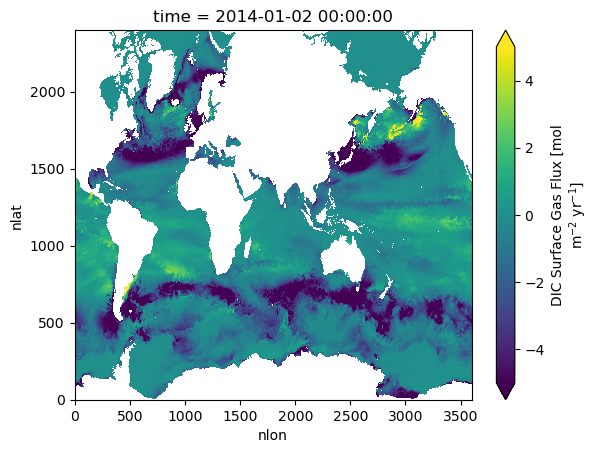

In [12]:
nmolcm2s_to_molm2yr = 1e4 * 1e-9 * 86400.0 * 365.0


with xr.open_dataset(files[-8]) as ds:
    fgco2 = ds["FG_CO2_2"].isel(time=0).load()
    fgco2 *= nmolcm2s_to_molm2yr * -1.0
    fgco2.attrs["units"] = "mol m$^{-2}$ yr$^{-1}$"

fgco2.plot(vmin=-5.0, vmax=5.0)

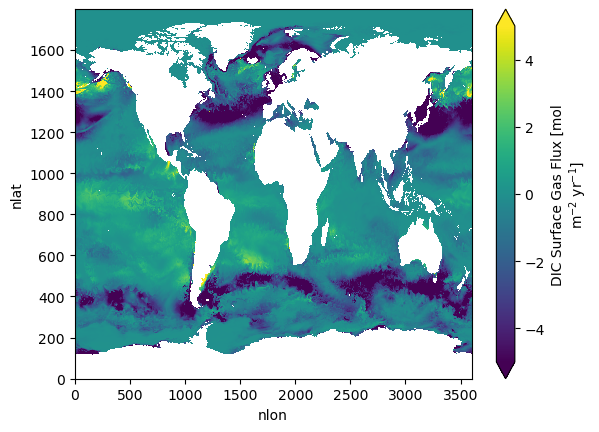

In [14]:
field_latlon = regrid_obj(fgco2)
field_latlon.plot(vmin=-5.0, vmax=5.0)

In [15]:
cluster, client = util.get_ClusterClient(memory="12GB", project=PROJECT)
cluster.scale(128)
client

/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.80:41379,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


2024-04-15 21:09:54,268 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p1229'}, 'attr': 'end', 'new': 787.5169428954844}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 97, in handle
    work = await handler(message, connection)
  File "/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/bokeh/server/connection.py", line 65, in session
    assert self._session is not None
AssertionError
2024-04-15 21:09:54,631 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kin

In [17]:
%%time
USER = os.environ["USER"]
diro = f"/glade/derecho/scratch/{USER}/fgco2-files"
check_call(["rm", "-fr", diro])
os.makedirs(diro, exist_ok=True)


@dask.delayed
def regrid_one_level(da_in, path_out):
    ds = regrid_obj(da_in.load()).to_dataset()
    ds.to_zarr(
        path_out,
        mode="w",
        consolidated=True,
    )
    return path_out


computed_objs = []
for f in files[-8:]:
    print(f)
    with xr.open_dataset(f, chunks={"time": 1}) as ds:
        fgco2 = ds.FG_CO2_2
        fgco2 *= nmolcm2s_to_molm2yr * -1.0
        fgco2.attrs["units"] = "mol m$^{-2}$ yr$^{-1}$"
        fgco2 = fgco2.persist()  # scatter to workers
        time = ds.time.load()

    del_objs = []
    for i in range(len(time)):
        path_out = f"{diro}/{case}.{time[i].values.item().strftime('%Y-%m-%d')}.zarr"
        del_objs.append(regrid_one_level(fgco2[i : i + 1, :, :], path_out))

    computed_objs.append(dask.compute(*del_objs))

/glade/campaign/collections/cmip/CMIP6/CESM-HR/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/day_1/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001.pop.h.nday1.FG_CO2_2.20140102-20150101.nc


/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 363.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


/glade/campaign/collections/cmip/CMIP6/CESM-HR/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/day_1/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001.pop.h.nday1.FG_CO2_2.20150102-20160101.nc


/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 363.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


/glade/campaign/collections/cmip/CMIP6/CESM-HR/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/day_1/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001.pop.h.nday1.FG_CO2_2.20160102-20170101.nc


/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 363.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


/glade/campaign/collections/cmip/CMIP6/CESM-HR/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/day_1/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001.pop.h.nday1.FG_CO2_2.20170102-20180101.nc


/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 363.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


/glade/campaign/collections/cmip/CMIP6/CESM-HR/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/day_1/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001.pop.h.nday1.FG_CO2_2.20180102-20190101.nc


/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 363.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


/glade/campaign/collections/cmip/CMIP6/CESM-HR/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/day_1/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001.pop.h.nday1.FG_CO2_2.20190102-20200101.nc


/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 363.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


/glade/campaign/collections/cmip/CMIP6/CESM-HR/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/day_1/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001.pop.h.nday1.FG_CO2_2.20200102-20210101.nc


/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 363.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


/glade/campaign/collections/cmip/CMIP6/CESM-HR/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/day_1/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001.pop.h.nday1.FG_CO2_2.20210102-20211231.nc


/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 363.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 1min 41s, sys: 3min 9s, total: 4min 50s
Wall time: 6min 14s
